We want to estimate the effect of 401(k) eligibility on net financial assets using double machine learning as in [this paper](https://arxiv.org/abs/1608.00060) with data from [here](https://github.com/kquist/DoubleML-Python).

In [1]:
import pandas as pd
df = pd.read_stata('sipp1991.dta')

print(df.shape)

df.sample(10)

(9915, 14)


,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
3319,4200.0,4200.0,51200.0,38,42036.0,5,16,1,1,1,0,0,0,1
3064,13.0,13.0,13.0,39,7023.0,5,8,1,0,0,0,0,0,0
6230,0.0,0.0,60500.0,45,7752.0,1,1,0,0,0,0,0,0,1
2118,0.0,-3550.0,11836.0,60,25356.0,1,4,0,0,0,0,0,0,1
3796,12000.0,7450.0,37450.0,34,20199.0,4,15,0,1,0,0,0,0,1
4140,700.0,100.0,6525.0,31,38802.0,6,12,1,0,0,0,0,0,0
4536,0.0,0.0,0.0,46,7854.0,3,11,0,0,0,0,0,0,0
9088,0.0,1000.0,1000.0,40,14040.0,2,12,1,0,0,1,1,0,0
8822,0.0,2000.0,47000.0,33,37056.0,4,12,0,1,0,1,1,0,0
79,800.0,800.0,7800.0,32,25314.0,1,12,0,0,0,0,0,0,0


# Estimator

As in [this paper](https://arxiv.org/abs/1608.00060), the model is
\begin{align*}
Y &= T\cdot\theta + m_Y(X) + R_Y, &E[R_Y|X, T] = 0,
\\
T &= m_T(X) + R_T, &E[R_T|X] = 0.
\end{align*}
To estimate $\theta$,
1. Partition the data set into $I_1$ and $I_2$.
1. For $k=1,2$
    1. Fit $Y$ versus $X$ on $I_k$ to approximate $m_Y$. Compute the residual $R_Y$ on $I_k^C$.
    1. Fit $T$ versus $X$ on $I_k$ to approximate $m_T$. Compute the residual $R_T$ on $I_k^C$.
    1. Fit a linear model for $R_Y$ versus $R_T$, giving an estimate $\theta_{k}$ for $\theta$.
1. Average $\theta_1$ and $\theta_{2}$.

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')


class DoubleML():
    
    def __init__(self, n_split=2, n_repeat=1):
        self.LinearModel = LinearRegression()
        self.n_split = n_split
        self.n_repeat = n_repeat
    
    def set_model(self, M):
        self.Model = M
        return self

    def set_df(self, df):
        self.df = df
        
        # n cross-splitting
        self.dfs = []
        indices = np.random.permutation(df.index)
        for i in np.array_split(indices, self.n_split):
            self.dfs.append(df.loc[i])

        # For two split...
        # self.df1 = df.sample(frac=0.5)
        # self.df2 = df.drop(self.df1.index)
        
        return self

    def set_outcomes(self, o):
        self.outcomes = o
        return self

    def set_treatments(self, t):
        self.treatments = t
        return self

    def set_controls(self, c=None):
        
        # Assign remaining columns if controls not set
        if c is None:
            c = [
                col for col in self.df.columns
                if col not in self.outcomes
                and col not in self.treatments
            ]
        
        self.controls = c
        return self

    def get_residual(self, df1, x, y, model):
        
        X1 = df1[x]
        Y1 = df1[y]
        
        # Predict on complement
        df2 = self.df.drop(df1.index)

        X2 = df2[x]
        Y2 = df2[y]
        
        Y2_pred = pd.DataFrame(columns=Y2.columns, index=df2.index)
        # FIXME need to reshape after sklearn 
        Y2_pred[Y2.columns] = model.fit(X1, Y1).predict(X2).reshape(-1, len(y))
        residual = Y2 - Y2_pred
        
        return residual
        
    def estimate_cross(self, df1):
        
        # Treatments vs Controls
        residual_tc = self.get_residual(
            df1, self.controls, self.treatments, self.Model
        )
        
        # Outcomes vs Controls
        residual_oc = self.get_residual(
            df1, self.controls, self.outcomes, self.Model
        )
        
        # Second vs First Residuals
        coef = self.LinearModel\
            .fit(residual_tc, residual_oc)\
            .coef_
        
        return pd.DataFrame(coef, columns=treatments)
    
    def estimate_once(self):
        
        coefs = []
        
        for df in self.dfs:
            coef = self.estimate_cross(df)
            coefs.append(coef)
        
        return pd.concat(coefs).reset_index(drop=True).mean().to_frame().transpose()
        
    def estimate(self):
        
        estimates = []
        for _ in range(self.n_repeat):
            estimate = self.estimate_once()
            estimates.append(estimate)
        return pd.concat(estimates).reset_index(drop=True)

# Example

Let's apply this to the data set.

In [3]:
from sklearn.ensemble import RandomForestRegressor

outcomes = ["nifa"]
treatments = ["marr"]

model = RandomForestRegressor(max_depth=2)

estimates = DoubleML(n_split=2, n_repeat=100)\
.set_model(model)\
.set_df(df)\
.set_outcomes(outcomes)\
.set_treatments(treatments)\
.set_controls()\
.estimate()

              marr
count   100.000000
mean   4616.986025
std     335.290015
min    3872.572980
25%    4375.594221
50%    4641.386679
75%    4838.324130
max    5351.436825


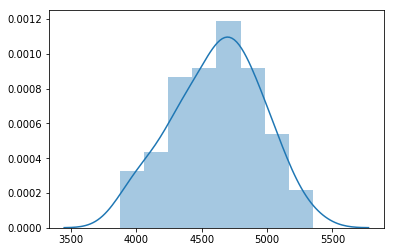

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# estimates.hist(bins=10)

import seaborn as sns
from scipy import stats

sns.distplot(estimates)
print(estimates.describe())